In [113]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, random
import equinox as eqx
import optax
import matplotlib.pyplot as plt

$ f: D \subset \mathbb{R} \rightarrow \mathbb{R}$, $ f(x) = \sqrt{|x|}$, $D = [-1, 1]^2$

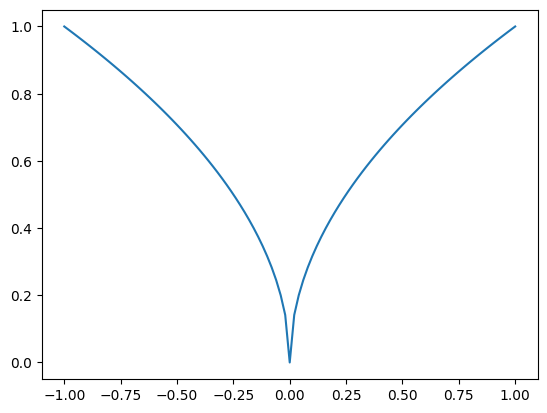

In [114]:
N = 101
x = jnp.expand_dims(jnp.linspace(-1, 1, N), axis=-1)
y = jnp.sqrt(jnp.abs(x))

fig, ax = plt.subplots()
ax.plot(x, y)

build a model

In [115]:
class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key):
        wkey, bkey = random.split(key)
        self.weight = random.normal(wkey, (out_size, in_size))
        self.bias = random.normal(bkey, (out_size,))

    def __call__(self, x):
        return self.weight @ x + self.bias

In [116]:
class NeuralNetwork(eqx.Module):
    layers: list

    def __init__(self, d_in, d_out, d_hidden, key):
        key1, key2, key3 = jax.random.split(key, 3)
        
        # These contain trainable parameters.
        self.layers = [eqx.nn.Linear(d_in, d_hidden, key=key1),
                       eqx.nn.Linear(d_hidden, d_hidden, key=key2),
                       eqx.nn.Linear(d_hidden, d_out, key=key3)]

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.tanh(layer(x))
        return self.layers[-1](x)

In [128]:
# Set a random key
key = random.PRNGKey(1)

# Generate random data for input
d_in, d_hidden, d_out = 1, 32, 1
batch_size = 1000

#model = Linear(in_size, out_size, key=key)
model = NeuralNetwork(in_size, out_size, d_hidden, key=key)

In [129]:
# get mean square error loss function
@jax.jit
@jax.grad
def loss(model, x, y):
    pred_y = vmap(model)(x)
    return jax.numpy.mean((y - pred_y) ** 2)

In [134]:
lr = 0.01
steps = 100000
for i in range(steps):
    grads = loss(model, x, y)
    model = jax.tree_util.tree_map(lambda m, g: m - lr * g, model, grads)

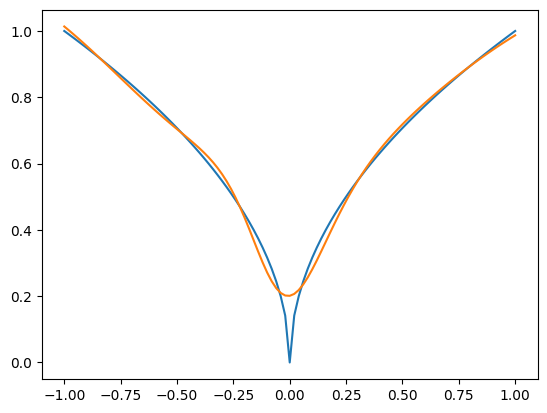

In [135]:
# evaluate results
y_pred = vmap(model)(x)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, y_pred)